# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Danmeng Cui
*   Student Number: 1004004356

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? **284807** **[0.1]**
* What features in the dataset are present aside from the 28 main features?  **'Time' and 'Amount'** **[0.1]**
* Which column contains the targets? **the column 31 'Class'** **[0.1]**
* To what do the target values correspond? **0 represents valid transaction, 1 represents fraud** **[0.1]**

In [ ]:
pip install wget

In [ ]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (1).gz'

In [ ]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0



* What is the percentage of entries in the dataset for each class?  **[0.1]**

    **The percentage for valid transaction (Class 0) is 99.82725143693799%**

    **The percentage for fraud transaction (Class 1) is 0.1727485630620034%**

* Is this data considered balanced or unbalanced? Why is this the case? **[0.1]** 

    **It is unbalanced, since the data has 99.82725143693799 percent of Class 0, and very small amount of Class 1.**

* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1?  **[0.2]**

    **It is important to be balanced, since the data distribution is biased when data is imbalanced, it can not represents the whole data. The test result is closer to the larger sized group.**

In [ ]:
print(sum(df['Class']==0)/284807) #transaction as valid (0)
print(sum(df['Class']==1)/284807) #transaction as fraud (1)

0.9982725143693799
0.001727485630620034


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [ ]:
from sklearn import neighbors
X=df[df.columns[0:30]]
y=df[df.columns[30]]

from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, random_state=0) #Split data ino 70% training data and 30% the rest.
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=0) #Split 30% the rest data into half validation data and half testing data. 

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

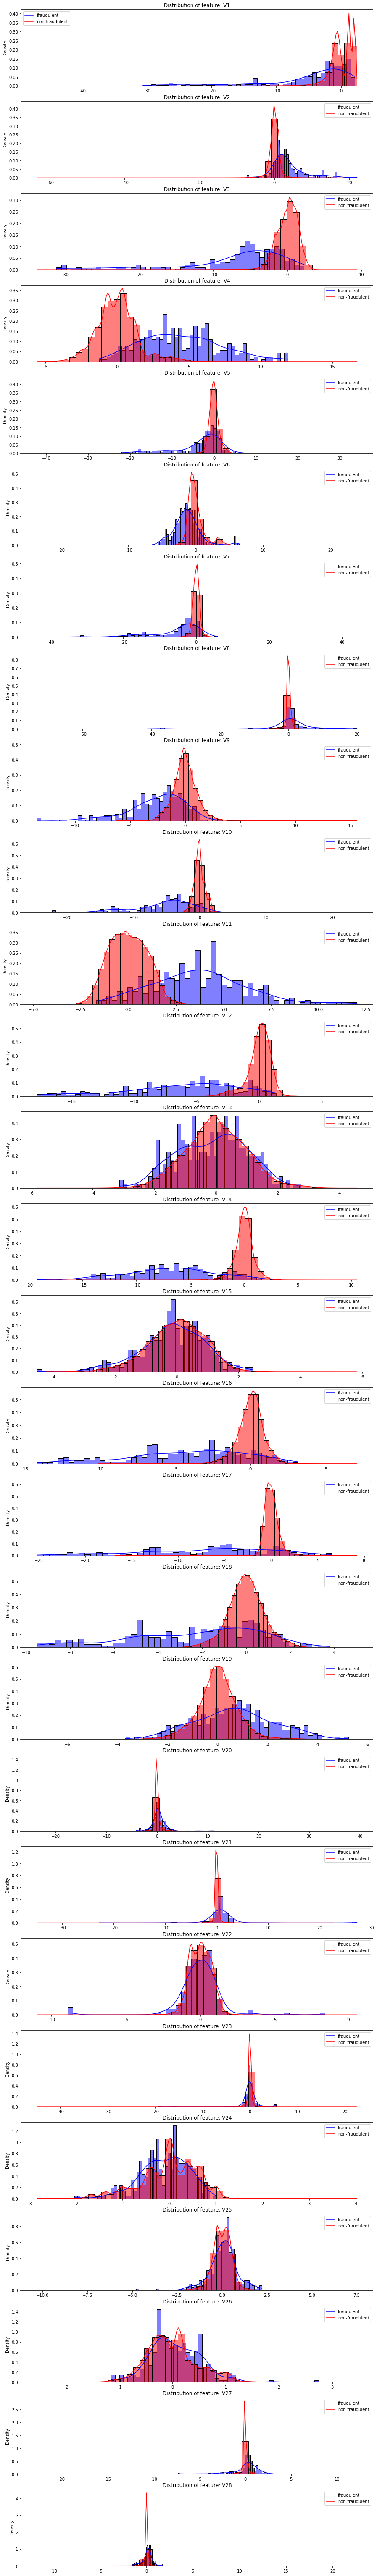

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

For V3, V7, V9, V10,V12, V14, V16 and V18, the fraudulent distribution is left skewed. For V4 and V11, the fraudulent distributions are right skewed. For V25, 26, 27, fraudulent and non fraud are overlapped. In order to make better prediction, we should only contain the features that have very different distributions for fraudulent and non-fraudulent. 

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





In [ ]:
#a. Fitting regardless of class:
import random
random.seed(1)
# Only for columnn 'V1':
#1. Fit a single Gaussian distribution on a single feature of the full training dataset (both classes) using sklearn.mixture.GaussianMixture when n_components=1.
from sklearn.mixture import GaussianMixture
gm_train = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_train.fit(X_train['V1'].to_frame())

gm_val = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val.fit(X_valid['V1'].to_frame())

#2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples on both the full training set and validation set (including both classes).
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

p_gm_train = gm_train.score_samples(X_train['V1'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_train, tpr_gm_train, _ = roc_curve(y_train, 1-p_gm_train)
print(auc(fpr_gm_train,tpr_gm_train)) #The AUC for tarining set is 0.7051015812269326

p_gm_val = gm_val.score_samples(X_valid['V1'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_valid, 1-p_gm_val)
print(auc(fpr_gm_val,tpr_gm_val)) #The AUC for tarining set is 0.6948175146212949

0.7051015812269326
0.6948175146212949


In [ ]:
#3. Repeat the above steps for each of the features and present your findings in a table.
import random
random.seed(1)

#For training set:
from sklearn.metrics import roc_auc_score
auc_train=[]
for i in range(1,29):
    gm_train_full = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
    gm_train_full.fit(X_train[df.columns[i]].to_frame())
    p_gm_train_full = gm_train_full.score_samples(X_train[df.columns[i]].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full training set
    fpr_gm_train_full, tpr_gm_train_full, _ = roc_curve(y_train, 1-p_gm_train_full)
    auc_train.append(roc_auc_score(y_train, 1-p_gm_train_full))
print(auc_train) #list of all auc for 28 features

AUC_train_table=pd.DataFrame(data=df.columns[1:29], columns=['Features'])
AUC_train_table['AUC']=auc_train
print(AUC_train_table)

#For validation set:
from sklearn.metrics import roc_auc_score
auc_val=[]
for i in range(1,29):
    gm_val_full = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
    gm_val_full.fit(X_valid[df.columns[i]].to_frame())
    p_gm_val_full = gm_val_full.score_samples(X_valid[df.columns[i]].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full validation set
    fpr_gm_val_full, tpr_gm_val_full, _ = roc_curve(y_valid, 1-p_gm_val_full)
    auc_val.append(roc_auc_score(y_valid, 1-p_gm_val_full))
print(auc_val) #list of all auc for 28 features

AUC_val_table=pd.DataFrame(data=df.columns[1:29], columns=['Features'])
AUC_val_table['AUC']=auc_val
print(AUC_val_table)

[0.7051015812269326, 0.8374993400600963, 0.8765373286404597, 0.8921026912367481, 0.7718253540864317, 0.7343799160971521, 0.8629666193840206, 0.773238328202733, 0.802874345039229, 0.9135997429711575, 0.8971751804921982, 0.9201801648680984, 0.5721515919643825, 0.9524586211308497, 0.5147644850163967, 0.9021367779975271, 0.9348519852193852, 0.8080298501832649, 0.7418740662077927, 0.7346917354260328, 0.8335210293445873, 0.5612872589326006, 0.6963263648776961, 0.4692288428364315, 0.574918030912641, 0.5032716780154484, 0.8354788061528755, 0.8142006105163218]
   Features       AUC
0        V1  0.705102
1        V2  0.837499
2        V3  0.876537
3        V4  0.892103
4        V5  0.771825
5        V6  0.734380
6        V7  0.862967
7        V8  0.773238
8        V9  0.802874
9       V10  0.913600
10      V11  0.897175
11      V12  0.920180
12      V13  0.572152
13      V14  0.952459
14      V15  0.514764
15      V16  0.902137
16      V17  0.934852
17      V18  0.808030
18      V19  0.741874
19

In [ ]:
#4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. 
AUC_val_table.sort_values("AUC", ascending=False)
# The best 3 features are 'V14', 'V10' and 'V4', with the maximum three corresponding AUC 0.938092, 0.905961 and 0.888610. 

,Features,AUC
13,V14,0.938092
9,V10,0.905961
3,V4,0.888610
15,V16,0.882755
10,V11,0.881981
16,V17,0.881756
6,V7,0.867483
2,V3,0.839276
11,V12,0.838776
1,V2,0.837433


In [ ]:
#5. Make a prediction based on a model's scores: If the score_samples is lower than a threshold, we consider that transaction as a fraud. 
# Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. 
# (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using sklearn.metrics.f1_score. 
import random
random.seed(1)

#For V14:
from sklearn.metrics import f1_score
gm_val_14 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_14.fit(X_valid['V14'].to_frame())
p_gm_val_14 = gm_val_14.score_samples(X_valid['V14'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full training set
f1_list_14=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_14)[i] #We sort the points by probability
   f1_14=f1_score(y_valid, p_gm_val_14 < mn_gm)
   f1_list_14.append(f1_14)
print(f1_list_14)
print(max(f1_list_14)) #0.5901639344262295
print(sorted(p_gm_val_14)[f1_list_14.index(max(f1_list_14))+1]) #-19.630983874816
#The maximum f1 score is 0.5901639344262295 and the threshold is -19.630983874816

#For V10:
from sklearn.metrics import f1_score
gm_val_10 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_10.fit(X_valid['V10'].to_frame())
p_gm_val_10 = gm_val_10.score_samples(X_valid['V10'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full training set
f1_list_10=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_10)[i] #We sort the points by probability
   f1_10=f1_score(y_valid, p_gm_val_10< mn_gm)
   f1_list_10.append(f1_10)
print(f1_list_10)
print(max(f1_list_10)) #0.2558139534883721
print(sorted(p_gm_val_10)[f1_list_10.index(max(f1_list_10))+1]) #-59.60932869378241
#The maximum f1 score is 0.2558139534883721 and the threshold is -59.60932869378241

#For V4:
from sklearn.metrics import f1_score
gm_val_4 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_4.fit(X_valid['V4'].to_frame())
p_gm_val_4 = gm_val_4.score_samples(X_valid['V4'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full training set
f1_list_4=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_4)[i] #We sort the points by probability
   f1_4=f1_score(y_valid, p_gm_val_4 < mn_gm)
   f1_list_4.append(f1_4)
print(f1_list_4)
print(max(f1_list_4)) #0.3619047619047619
print(sorted(p_gm_val_4)[f1_list_4.index(max(f1_list_4))+1]) #-11.193682501598063
#The maximum f1 score is 0.3619047619047619 and the threshold is -11.193682501598063

[0.029411764705882353, 0.05797101449275362, 0.08571428571428572, 0.08571428571428572, 0.13888888888888887, 0.1643835616438356, 0.18918918918918917, 0.21333333333333335, 0.2368421052631579, 0.23376623376623376, 0.2564102564102564, 0.2784810126582279, 0.275, 0.2962962962962963, 0.3170731707317074, 0.3373493975903615, 0.33333333333333337, 0.3529411764705882, 0.37209302325581395, 0.39080459770114945, 0.40909090909090906, 0.42696629213483145, 0.4222222222222222, 0.4395604395604395, 0.4565217391304348, 0.4731182795698925, 0.4893617021276595, 0.5052631578947367, 0.5, 0.4948453608247423, 0.4897959183673469, 0.48484848484848486, 0.5, 0.4950495049504951, 0.5098039215686275, 0.5048543689320389, 0.5192307692307693, 0.5142857142857143, 0.5094339622641508, 0.5233644859813084, 0.5370370370370371, 0.5321100917431193, 0.5454545454545455, 0.5585585585585586, 0.5535714285714286, 0.5486725663716814, 0.5614035087719299, 0.5739130434782609, 0.5689655172413793, 0.5641025641025641, 0.576271186440678, 0.571428

In [ ]:
#6. Report the complexity of your method (Big O notation) for determining the optimal threshold.
# The running time for determining the optimal threshold should be O(nlogn).
# Since sort has the running time O(nlogn), the for loop has running time O(n), max has O(n), therefore, the maximum running time should be O(nlogn).

In [ ]:
#b. Fitting based on class:
#1. Pick 3 features that had the best AUC in Part 2a.
# V14, V10, V4

#2. Compute AUC and F1 score when you fit a Gaussian only on non-fraudulent transactions (instead of all the transactions).
X_val_nf = X_valid[y_valid ==0] 
#V14:
#AUC
gm_val_14_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_14_nf.fit(X_val_nf['V14'].to_frame())

p_gm_val_14_nf = gm_val_14_nf.score_samples(X_valid['V14'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_14_nf, tpr_gm_val_14_nf, _ = roc_curve(y_valid, 1-p_gm_val_14_nf) 
print(auc(fpr_gm_val_14_nf,tpr_gm_val_14_nf)) #The AUC for tarining set is 0.9380688343344468
#F1
f1_list_14_nf=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_nf = sorted(p_gm_val_14_nf)[i] #We sort the points by probability
   f1_14_nf=f1_score(y_valid, p_gm_val_14_nf < mn_gm_nf)
   f1_list_14_nf.append(f1_14_nf)
print(max(f1_list_14_nf)) #0.5901639344262295

#V10:
#AUC
gm_val_10_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_10_nf.fit(X_val_nf['V10'].to_frame())

p_gm_val_10_nf = gm_val_10_nf.score_samples(X_valid['V10'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_10_nf, tpr_gm_val_10_nf, _ = roc_curve(y_valid, 1-p_gm_val_10_nf) 
print(auc(fpr_gm_val_10_nf,tpr_gm_val_10_nf)) #The AUC for tarining set is 0.9059198311439007
#F1
f1_list_10_nf=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_nf = sorted(p_gm_val_10_nf)[i] #We sort the points by probability
   f1_10_nf=f1_score(y_valid, p_gm_val_10_nf < mn_gm_nf)
   f1_list_10_nf.append(f1_10_nf)
print(max(f1_list_10_nf)) #0.2558139534883721

#V4:
#AUC
gm_val_4_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_val_4_nf.fit(X_val_nf['V4'].to_frame())

p_gm_val_4_nf = gm_val_4_nf.score_samples(X_valid['V4'].to_frame()) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_4_nf, tpr_gm_val_4_nf, _ = roc_curve(y_valid, 1-p_gm_val_4_nf) 
print(auc(fpr_gm_val_4_nf,tpr_gm_val_4_nf)) #The AUC for tarining set is0.8890342212135273
f1_list_4_nf=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_nf = sorted(p_gm_val_4_nf)[i] #We sort the points by probability
   f1_4_nf=f1_score(y_valid, p_gm_val_4_nf < mn_gm_nf)
   f1_list_4_nf.append(f1_4_nf)
print(max(f1_list_4_nf)) #0.3619047619047619

0.9380688343344468
0.5901639344262295
0.9059198311439007
0.2558139534883721
0.8890342212135273
0.3619047619047619


In [ ]:
#3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table.
l=['V14','V10','V4']
table=pd.DataFrame(data=l, columns=['Features'])
table['AUC regardless class']=[AUC_val_table.iloc[13]['AUC'], AUC_val_table.iloc[9]['AUC'], AUC_val_table.iloc[3]['AUC']]
table['AUC non-fraudulent']=[auc(fpr_gm_val_14_nf,tpr_gm_val_14_nf), auc(fpr_gm_val_10_nf,tpr_gm_val_10_nf), auc(fpr_gm_val_4_nf,tpr_gm_val_4_nf)]
table['F1 regardless class']=[max(f1_list_14), max(f1_list_10), max(f1_list_4)]
table['F1 non-fraudulent']=[max(f1_list_14_nf),max(f1_list_10_nf),max(f1_list_4_nf)]
table

,Features,AUC regardless class,AUC non-fraudulent,F1 regardless class,F1 non-fraudulent
0,V14,0.938092,0.938069,0.590164,0.590164
1,V10,0.905961,0.905920,0.255814,0.255814
2,V4,0.888610,0.889034,0.361905,0.361905


In [ ]:
#4. Are these results different or similar? Why?
# The results are very close, since the size for both of the validation set and the fraudulent data are very small, there are too few fraudulent transctions in validation set
# which can not impact the whole data a lot. 

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





0.8834102577490416
0.8748702681556348


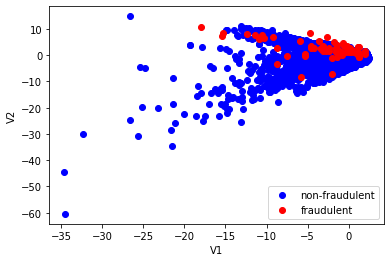

In [ ]:
#1. Pick two features: 'V1' and 'V2'
#2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis).
#3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
import matplotlib.pyplot as plt
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 
plt.scatter(X_val_nf['V1'], X_val_nf['V2'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V1'], X_val_f['V2'], label='fraudulent',color='red')
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend()

#4. Based on your plots, decide how many Gaussian components (n_components) you need to fit the data (focus on valid transactions). Explain.
# At least three Gaussian components should be used, many points are concentrated around (0,0), another part concentrates around where 'fraudulent' concentrates,
# there's one part spread on the left lower part.  

#5. Fit your Gaussian model on all the data points.
gm_train_1_2 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
gm_train_1_2.fit(X_train[['V1','V2']]) #fit the training set

gm_val_1_2 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
gm_val_1_2.fit(X_valid[['V1','V2']]) #fit the validation set

#6. Compute AUC on both training and validation sets
p_gm_train_1_2 = gm_train_1_2.score_samples(X_train[['V1','V2']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_train_1_2, tpr_gm_train_1_2, _ = roc_curve(y_train, 1-p_gm_train_1_2)
print(auc(fpr_gm_train_1_2,tpr_gm_train_1_2)) #The AUC for training set is 0.8958236311688486

p_gm_val_1_2 = gm_val_1_2.score_samples(X_valid[['V1','V2']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_1_2, tpr_gm_val_1_2, _ = roc_curve(y_valid, 1-p_gm_val_1_2)
print(auc(fpr_gm_val_1_2,tpr_gm_val_1_2)) #The AUC for validation set is 0.8887016017447996

0.9366360257934735
0.896139292285233


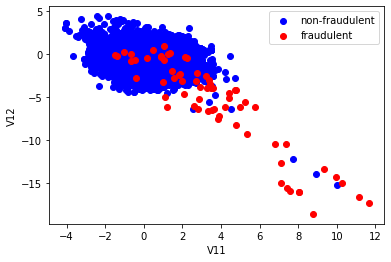

In [ ]:
#7. Pick 3 new pairs of features and repeat steps 2 to 6.
#7.1.1. Pick three features: ['V11', 'V12'] and ['V3','V4'] and ['V5','V6']

#'V11' vs. 'V12'
#2. Scatter plot (plt.scatter) those features on a figure 
#3. Color the data points based on their class (non-fraudulent blue and fraudulent red).

import matplotlib.pyplot as plt
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 
plt.scatter(X_val_nf['V11'], X_val_nf['V12'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V11'], X_val_f['V12'], label='fraudulent',color='red')
plt.xlabel("V11")
plt.ylabel("V12")
plt.legend()

#4. Based on your plots, decide how many Gaussian components (n_components) you need to fit the data (focus on valid transactions). Explain.
# At least two Gaussian components should be used, many points are concentrated around (0,0), another part concentrates around where 'fraudulent' concentrates,

#5. Fit your Gaussian model on all the data points.
gm_train_11_12 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm_train_11_12.fit(X_train[['V11','V12']]) #fit the training set

gm_val_11_12 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm_val_11_12.fit(X_valid[['V11','V12']]) #fit the validation set

#6. Compute AUC on both training and validation sets
p_gm_train_11_12 = gm_train_11_12.score_samples(X_train[['V11','V12']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_train_11_12, tpr_gm_train_11_12, _ = roc_curve(y_train, 1-p_gm_train_11_12)
print(auc(fpr_gm_train_11_12,tpr_gm_train_11_12)) #The AUC for training set is 0.9366360257934735

p_gm_val_11_12 = gm_val_11_12.score_samples(X_valid[['V11','V12']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_11_12, tpr_gm_val_11_12, _ = roc_curve(y_valid, 1-p_gm_val_11_12)
print(auc(fpr_gm_val_11_12,tpr_gm_val_11_12)) #The AUC for validation set is 0.896139292285233

0.931296458403833
0.9225902419258329


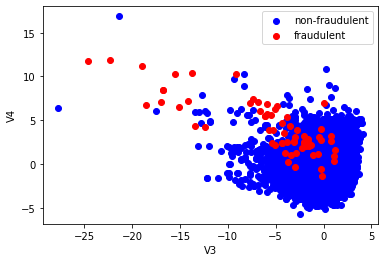

In [ ]:
#'V3' vs. 'V4'
#2. Scatter plot (plt.scatter) those features on a figure 
#3. Color the data points based on their class (non-fraudulent blue and fraudulent red).

import matplotlib.pyplot as plt
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 
plt.scatter(X_val_nf['V3'], X_val_nf['V4'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V3'], X_val_f['V4'], label='fraudulent',color='red')
plt.xlabel("V3")
plt.ylabel("V4")
plt.legend()

#4. Based on your plots, decide how many Gaussian components (n_components) you need to fit the data (focus on valid transactions). Explain.
# At least three Gaussian components should be used, many points are concentrated around (0,0), another part concentrates around where 'fraudulent' concentrates,
# there's some value on right top of the plot. 

#5. Fit your Gaussian model on all the data points.
gm_train_3_4 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
gm_train_3_4.fit(X_train[['V3','V4']]) #fit the training set

gm_val_3_4 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
gm_val_3_4.fit(X_valid[['V3','V4']]) #fit the validation set

#6. Compute AUC on both training and validation sets
p_gm_train_3_4 = gm_train_3_4.score_samples(X_train[['V3','V4']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_train_3_4, tpr_gm_train_3_4, _ = roc_curve(y_train, 1-p_gm_train_3_4)
print(auc(fpr_gm_train_3_4,tpr_gm_train_3_4)) #The AUC for training set is0.931296458403833

p_gm_val_3_4 = gm_val_3_4.score_samples(X_valid[['V3','V4']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_3_4, tpr_gm_val_3_4, _ = roc_curve(y_valid, 1-p_gm_val_3_4)
print(auc(fpr_gm_val_3_4,tpr_gm_val_3_4)) #The AUC for validation set is 0.9225902419258329

0.831446520545595
0.778436555441949


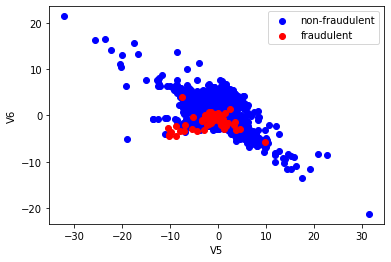

In [ ]:
#'V5' vs. 'V6'
#2. Scatter plot (plt.scatter) those features on a figure 
#3. Color the data points based on their class (non-fraudulent blue and fraudulent red).

import matplotlib.pyplot as plt
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 
plt.scatter(X_val_nf['V5'], X_val_nf['V6'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V5'], X_val_f['V6'], label='fraudulent',color='red')
plt.xlabel("V5")
plt.ylabel("V6")
plt.legend()

#4. Based on your plots, decide how many Gaussian components (n_components) you need to fit the data (focus on valid transactions). Explain.
# At least four Gaussian components should be used, many points are concentrated around (0,0), another part concentrates top left,
# there's some value on lower right of the plot, there's a small portion on lower left. 

#5. Fit your Gaussian model on all the data points.
gm_train_5_6 = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
gm_train_5_6.fit(X_train[['V5','V6']]) #fit the training set

gm_val_5_6 = GaussianMixture(n_components = 4,
                    covariance_type = 'full', random_state=0, )
gm_val_5_6.fit(X_valid[['V5','V6']]) #fit the validation set

#6. Compute AUC on both training and validation sets
p_gm_train_5_6 = gm_train_5_6.score_samples(X_train[['V5','V6']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_train_5_6, tpr_gm_train_5_6, _ = roc_curve(y_train, 1-p_gm_train_5_6)
print(auc(fpr_gm_train_5_6,tpr_gm_train_5_6)) #The AUC for training set is 0.831446520545595

p_gm_val_5_6 = gm_val_5_6.score_samples(X_valid[['V5','V6']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_val_5_6, tpr_gm_val_5_6, _ = roc_curve(y_valid, 1-p_gm_val_5_6)
print(auc(fpr_gm_val_5_6,tpr_gm_val_5_6)) #The AUC for validation set is 0.778436555441949

In [ ]:
#8. For each pair, find a threshold to maximize your validation set F1 Score.
#'V11' vs. 'V12'
f1_list_11_12=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_11_12)[i] #We sort the points by probability
   f1_11_12=f1_score(y_valid, p_gm_val_11_12 < mn_gm)
   f1_list_11_12.append(f1_11_12)
print(max(f1_list_11_12)) # max F1 score 0.5470085470085471
print(sorted(p_gm_val_11_12)[f1_list_11_12.index(max(f1_list_11_12))+1]) # threshold -9.506020721597773

#'V3' vs. 'V4'
f1_list_3_4=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_3_4)[i] #We sort the points by probability
   f1_3_4=f1_score(y_valid, p_gm_val_3_4 < mn_gm)
   f1_list_3_4.append(f1_3_4)
print(max(f1_list_3_4)) # max F1 score 0.29213483146067415
print(sorted(p_gm_val_3_4)[f1_list_3_4.index(max(f1_list_3_4))+1]) # threshold -13.830228224946106

#'V5' vs. 'V6'
f1_list_5_6=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm = sorted(p_gm_val_5_6)[i] #We sort the points by probability
   f1_5_6=f1_score(y_valid, p_gm_val_5_6 < mn_gm)
   f1_list_5_6.append(f1_5_6)
print(max(f1_list_5_6)) # max F1 score 0.17391304347826084
print(sorted(p_gm_val_5_6)[f1_list_5_6.index(max(f1_list_5_6))+1]) # threshold -12.477486286585547

0.5470085470085471
-9.506020721597773
0.29213483146067415
-13.830228224946106
0.17391304347826084
-12.477486286585547


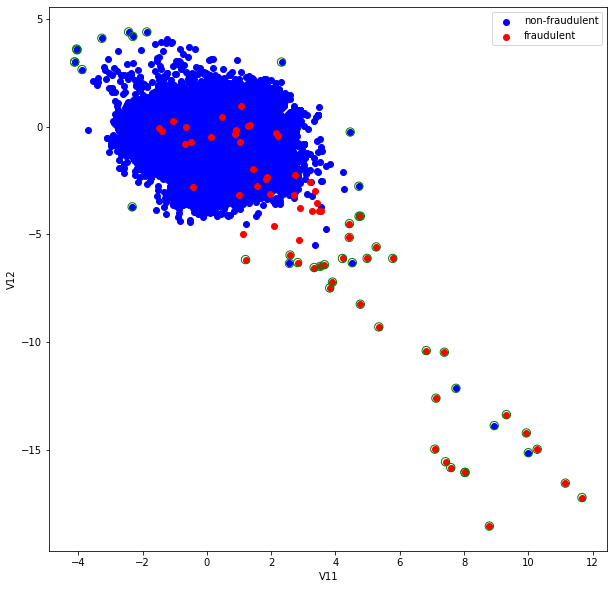

In [ ]:
#9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial)

#'V11' vs. 'V12'
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 

plt.figure(figsize=(10,10))
plt.scatter(X_val_nf['V11'], X_val_nf['V12'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V11'], X_val_f['V12'], label='fraudulent',color='red')
c = gm_val_11_12.score_samples(X_valid[['V11','V12']])
threshold= sorted(p_gm_val_11_12)[f1_list_11_12.index(max(f1_list_11_12))+1]
outliers = c<threshold
plt.scatter(X_valid[['V11']][outliers],X_valid[['V12']][outliers],marker="o",facecolor= "none",edgecolor="green",s=70)
plt.xlabel("V11")
plt.ylabel("V12")
plt.legend()
plt.show()

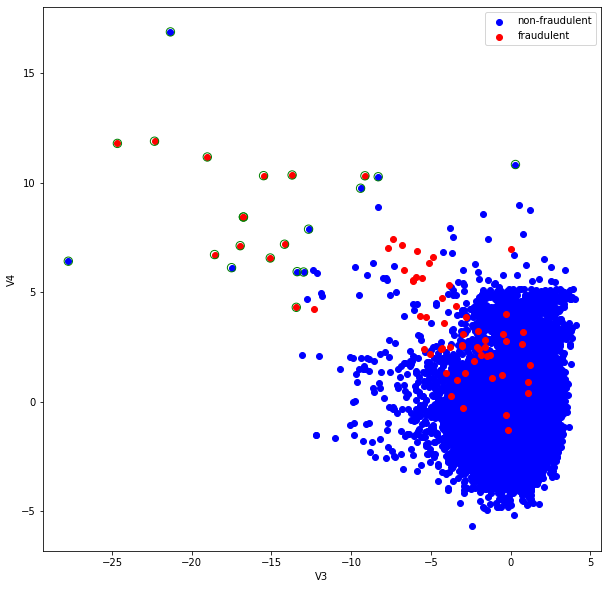

In [ ]:
#'V3' vs. 'V4'
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 

plt.figure(figsize=(10,10))
plt.scatter(X_val_nf['V3'], X_val_nf['V4'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V3'], X_val_f['V4'], label='fraudulent',color='red')
c = gm_val_3_4.score_samples(X_valid[['V3','V4']])
threshold= sorted(p_gm_val_3_4)[f1_list_3_4.index(max(f1_list_3_4))+1]
outliers = c<threshold
plt.scatter(X_valid[['V3']][outliers],X_valid[['V4']][outliers],marker="o",facecolor= "none",edgecolor="green",s=70)
plt.xlabel("V3")
plt.ylabel("V4")
plt.legend()
plt.show()

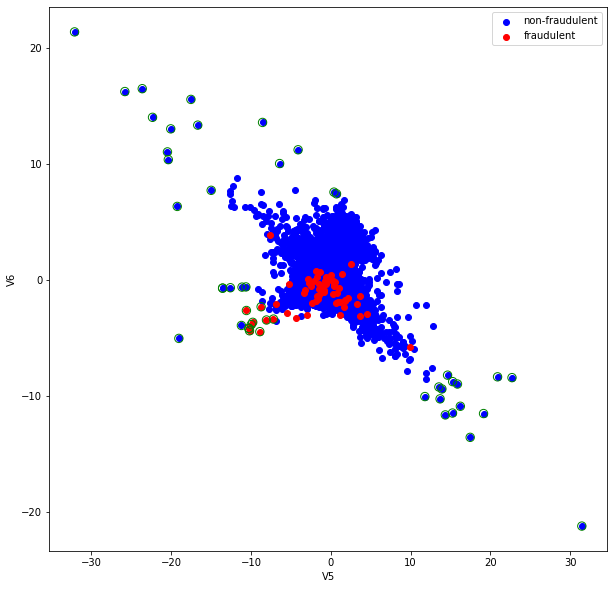

In [ ]:
#'V5' vs. 'V6'
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1] 

plt.figure(figsize=(10,10))
plt.scatter(X_val_nf['V5'], X_val_nf['V6'], label='non-fraudulent', color='blue')
plt.scatter(X_val_f['V5'], X_val_f['V6'], label='fraudulent',color='red')
c = gm_val_5_6.score_samples(X_valid[['V5','V6']])
threshold= sorted(p_gm_val_5_6)[f1_list_5_6.index(max(f1_list_5_6))+1]
outliers = c<threshold
plt.scatter(X_valid[['V5']][outliers],X_valid[['V6']][outliers],marker="o",facecolor= "none",edgecolor="green",s=70)
plt.xlabel("V5")
plt.ylabel("V6")
plt.legend()
plt.show()

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [ ]:
#1. Fit a Gaussian distribution ( 𝐺1 ) on a feature of non-fraudulent transactions using sklearn.mixture.GaussianMixture when n_components=1. 
X_val_nf = X_valid[y_valid ==0]
gm_val_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1=gm_val_nf.fit(X_val_nf['V1'].to_frame()) #fit the validation set

#2. Fit another Gaussian distribution ( 𝐺2 ) on the same feature but for fraudulent transactions using sklearn.mixture.GaussianMixture when n_components=1.
X_val_f = X_valid[y_valid ==1]
gm_val_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2=gm_val_f.fit(X_val_f['V1'].to_frame()) #fit the validation set

#3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the validation set to get  𝑆1  and  𝑆2 , respectively.
S1=G1.score_samples(X_valid['V1'].to_frame())
S2=G2.score_samples(X_valid['V1'].to_frame())

#4. Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score for a model such that if  𝑆1<𝑐×𝑆2 , 
# the transaction is classified as a fraud. For example, if  𝑐=1  we could say that if  𝑆2  is greater than  𝑆1 , ( 𝑆1 < 𝑆2 ) then the transaction is a fraud 
# (the transaction belongs to the  𝐺2  distribution which represents fraudulent transactions). 
# For start consider  𝑐  in  [0,10]  with steps of 0.1, you can change this window in your experiments if needed.
f1_list_S_V1=[]
c_S_V1=[]
for c in np.arange(0,10,0.1):
    f1_S_V1 = f1_score(y_valid, S1 < c *S2)
    c_S_V1.append(c)
    f1_list_S_V1.append(f1_S_V1)
print(max(f1_list_S_V1))
print(c_S_V1[f1_list_S_V1.index(max(f1_list_S_V1))])
#Therefore, the optimum F1 sacore is 0.09661835748792269 and the corresponding c is 4.5

0.09661835748792269
4.5


In [ ]:
# 5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c?
# training set
import math
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]
gm_train_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_train_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
V1_V28=df.columns[1:29]
f1_list_S_all=[]
c_S_all=[]
for i in V1_V28:
    G1_all=gm_train_nf.fit(X_train_nf[i].to_frame()) #fit the training set
    G2_all=gm_train_f.fit(X_train_f[i].to_frame()) #fit the training set
    S1_all=G1_all.score_samples(X_train[i].to_frame())
    S2_all=G2_all.score_samples(X_train[i].to_frame())
    for c in np.arange(0,10,0.1):
        f1_S_all = f1_score(y_train, S1_all < c *S2_all)
        c_S_all.append(c)
        f1_list_S_all.append(f1_S_all)
        
print(max(f1_list_S_all))
print(f1_list_S_all.index(max(f1_list_S_all)))
print(c_S_all[f1_list_S_all.index(max(f1_list_S_all))])
print( math.floor(f1_list_S_all.index(max(f1_list_S_all))/100))
#Therefore, the optimum F1 sacore is 0.6866666666666666 and the corresponding c is 5.0, the feature is V11

#Validation set
import math
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]

V1_V28=df.columns[1:29]
f1_list_S_all=[]
c_S_all=[]
for i in V1_V28:
    G1_all=gm_val_nf.fit(X_val_nf[i].to_frame()) #fit the validation set
    G2_all=gm_val_f.fit(X_val_f[i].to_frame()) #fit the validation set
    S1_all=G1_all.score_samples(X_valid[i].to_frame())
    S2_all=G2_all.score_samples(X_valid[i].to_frame())
    for c in np.arange(0,10,0.1):
        f1_S_all = f1_score(y_valid, S1_all < c *S2_all)
        c_S_all.append(c)
        f1_list_S_all.append(f1_S_all)
        
print(max(f1_list_S_all))
print(f1_list_S_all.index(max(f1_list_S_all)))
print(c_S_all[f1_list_S_all.index(max(f1_list_S_all))])
print( math.floor(f1_list_S_all.index(max(f1_list_S_all))/100))
#Therefore, the optimum F1 sacore is 0.6545454545454547 and the corresponding c is 7.9, the feature is V16

0.6866666666666666
1150
5.0
11
0.6545454545454547
1679
7.9
16


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

In [ ]:
# Model1: 1 Gaussian, single component, 2 features(V14,V10), training set
# Model2: 1 Gaussian, single component, 2 features(V14,V10), validation set
# Model3: 1 Gaussian, single component, 3 features(V14,V10,V4) training set
# Model4: 1 Gaussian, single component, 3 features(V14,V10,V4) validation set

# Model5: 1 Gaussian, 2 component, 2 features(V14,V10)  training set
# Model6: 1 Gaussian, 2 component, 2 features(V14,V10)  validation set

# Model7: 2 Gaussian, 2 component, 2 features(V14,V10)  training set
# Model8: 2 Gaussian, 2 component, 2 features(V14,V10) validation set

# Model9: 2 Gaussian, single component, 2 features(V14,V10)  training set
# Model10: 2 Gaussian, single component, 2 features(V14,V10)  validation set

# Model11: 1 Gaussian, 2 component, 3 features(V14,V10,V4)  training set
# Model12: 1 Gaussian, 2 component, 3 features(V14,V10,V4)  validation set

# Model13: 2 Gaussian, 2 component, 3 features(V14,V10,V4)  training set
# Model14: 2 Gaussian, 2 component, 3 features(V14,V10,V4) validation set

# Model15: 2 Gaussian, single component, 3 features(V14,V10,V4)  training set
# Model16: 2 Gaussian, single component, 3 features(V14,V10,V4)  validation set

#Model17: 1 Gaussian, 3 component, 2 features(V14,V10)  training set
#Model18: 1 Gaussian, 3 component, 2 features(V14,V10)  validation set

#Model19: 2 Gaussian, 3 component, 2 features(V14,V10)  training set
#Model20: 2 Gaussian, 3 component, 2 features(V14,V10) validation set

#Model21: 1 Gaussian, 3 component, 3 features(V14,V10,V4)  training set
#Model22: 1 Gaussian, 3 component, 3 features(V14,V10,V4)  validation set

#Model23: 2 Gaussian, 3 component, 3 features(V14,V10,V4)  training set
#Model24: 2 Gaussian, 3 component, 3 features(V14,V10,V4) validation set

# Model1: 1 Gaussian, single component, 2 features(V14,V10), training set 
m1 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m1.fit(X_train[['V14','V10']]) #fit the training set

#AUC
p_gm_m1 = m1.score_samples(X_train[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m1, tpr_gm_m1, _ = roc_curve(y_train, 1-p_gm_m1)
print(auc(fpr_gm_m1,tpr_gm_m1)) #The AUC for training set is 0.9538028522657257

#F1
f1_list_m1=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m1 = sorted(p_gm_m1)[i] #We sort the points by probability
   f1_m1=f1_score(y_train, p_gm_m1 < mn_gm_m1)
   f1_list_m1.append(f1_m1)
print(max(f1_list_m1)) # max F1 score 0.3513513513513513
print(sorted(p_gm_m1)[f1_list_m1.index(max(f1_list_m1))+1]) # threshold -88.87989315467945

0.9538028522657257
0.3513513513513513
-88.87989315467945


In [ ]:
# Model2: 1 Gaussian, single component, 2 features(V14,V10), validation set 
m2 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m2.fit(X_valid[['V14','V10']]) #fit the validation set

#AUC
p_gm_m2 = m2.score_samples(X_valid[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m2, tpr_gm_m2, _ = roc_curve(y_valid, 1-p_gm_m2)
print(auc(fpr_gm_m2,tpr_gm_m2)) #The AUC for training set is 0.9515385514402946

#F1
f1_list_m2=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m2 = sorted(p_gm_m2)[i] #We sort the points by probability
   f1_m2=f1_score(y_valid, p_gm_m2 < mn_gm_m2)
   f1_list_m2.append(f1_m2)
print(max(f1_list_m2)) # max F1 score 0.38571428571428573
print(sorted(p_gm_m2)[f1_list_m2.index(max(f1_list_m2))+1]) # threshold -42.809103316548466

0.9515385514402946
0.38571428571428573
-42.809103316548466


In [ ]:
# Model3: 1 Gaussian, single component, 3 features(V14,V10,V4), training set 
m3 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m3.fit(X_train[['V14','V10','V4']]) #fit the training set

#AUC
p_gm_m3 = m3.score_samples(X_train[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m3, tpr_gm_m3, _ = roc_curve(y_train, 1-p_gm_m3)
print(auc(fpr_gm_m3,tpr_gm_m3)) #The AUC for training set is 0.9632681928045468

#F1
f1_list_m3=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m3 = sorted(p_gm_m3)[i] #We sort the points by probability
   f1_m3=f1_score(y_train, p_gm_m3 < mn_gm_m3)
   f1_list_m3.append(f1_m3)
print(max(f1_list_m3)) # max F1 score 0.34684684684684686
print(sorted(p_gm_m3)[f1_list_m3.index(max(f1_list_m3))+1]) # threshold -100.01030858570147

0.9632681928045468
0.34684684684684686
-100.01030858570147


In [ ]:
# Model4: 1 Gaussian, single component, 3 features(V14,V10, V4), validation set 
m4 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
m4.fit(X_valid[['V14','V10','V4']]) #fit the validation set

#AUC
p_gm_m4 = m4.score_samples(X_valid[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m4, tpr_gm_m4, _ = roc_curve(y_valid, 1-p_gm_m4)
print(auc(fpr_gm_m4,tpr_gm_m4)) #The AUC for training set is 0.9485964466596544

#F1
f1_list_m4=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m4 = sorted(p_gm_m4)[i] #We sort the points by probability
   f1_m4=f1_score(y_valid, p_gm_m4 < mn_gm_m4)
   f1_list_m4.append(f1_m4)
print(max(f1_list_m4)) # max F1 score 0.4148148148148148
print(sorted(p_gm_m4)[f1_list_m4.index(max(f1_list_m4))+1]) # threshold -47.963005673204144

0.9485964466596544
0.4148148148148148
-47.963005673204144


In [ ]:
# Model5: 1 Gaussian, 2 component, 2 features(V14,V10)  training set
m5 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
m5.fit(X_train[['V14','V10']]) #fit the training set

#AUC
p_gm_m5 = m5.score_samples(X_train[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m5, tpr_gm_m5, _ = roc_curve(y_train, 1-p_gm_m5)
print(auc(fpr_gm_m5,tpr_gm_m5)) #The AUC for training set is 0.9543920320476285

#F1
f1_list_m5=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m5 = sorted(p_gm_m5)[i] #We sort the points by probability
   f1_m5=f1_score(y_train, p_gm_m5 < mn_gm_m5)
   f1_list_m5.append(f1_m5)
print(max(f1_list_m5)) # max F1 score 0.34234234234234234
print(sorted(p_gm_m5)[f1_list_m5.index(max(f1_list_m5))+1]) # threshold -17.704939529610005

0.9543920320476285
0.34234234234234234
-17.704939529610005


In [ ]:
# Model6: 1 Gaussian, 2 component, 2 features(V14,V10), validation set 
m6 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
m6.fit(X_valid[['V14','V10']]) #fit the validation set

#AUC
p_gm_m6 = m6.score_samples(X_valid[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m6, tpr_gm_m6, _ = roc_curve(y_valid, 1-p_gm_m6)
print(auc(fpr_gm_m6,tpr_gm_m6)) #The AUC for training set is 0.9522030444206034

#F1
f1_list_m6=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m6 = sorted(p_gm_m6)[i] #We sort the points by probability
   f1_m6=f1_score(y_valid, p_gm_m6 < mn_gm_m6)
   f1_list_m6.append(f1_m6)
print(max(f1_list_m6)) # max F1 score 0.38571428571428573
print(sorted(p_gm_m6)[f1_list_m6.index(max(f1_list_m6))+1]) # threshold -11.75648764562374

0.9522030444206034
0.38571428571428573
-11.75648764562374


In [ ]:
# Model7: 2 Gaussian, 2 component, 2 features(V14,V10)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m7_nf = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G1_m7=gm_m7_nf.fit(X_train_nf[['V14','V10']]) #fit the training set
gm_m7_f = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2_m7=gm_m7_f.fit(X_train_f[['V14','V10']]) #fit the training set
S1_m7=G1_m7.score_samples(X_train[['V14','V10']])
S2_m7=G2_m7.score_samples(X_train[['V14','V10']])

#AUC
fpr_gm_m7, tpr_gm_m7, _ = roc_curve(y_train, 1-S1_m7)
print(auc(fpr_gm_m7,tpr_gm_m7)) #AUC is 0.9552885599517809

#F1
f1_list_m7=[]
c_m7=[]
for c in np.arange(0,10,0.1):
    f1_m7 = f1_score(y_train, S1_m7 < c *S2_m7)
    c_m7.append(c)
    f1_list_m7.append(f1_m7)
print(max(f1_list_m7))
print(c_m7[f1_list_m7.index(max(f1_list_m7))])
#Therefore, the optimum F1 sacore is 0.7804154302670623 and the corresponding c is 2.2

0.9552885599517809
0.7804154302670623
2.2


In [ ]:
# Model8: 2 Gaussian, 2 component, 2 features(V14,V10) validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m8_nf = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G1_m8=gm_m8_nf.fit(X_val_nf[['V14','V10']]) #fit the validation set
gm_m8_f = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2_m8=gm_m8_f.fit(X_val_f[['V14','V10']]) #fit the validation set
S1_m8=G1_m8.score_samples(X_valid[['V14','V10']])
S2_m8=G2_m8.score_samples(X_valid[['V14','V10']])

#AUC
fpr_gm_m8, tpr_gm_m8, _ = roc_curve(y_valid, 1-S1_m8)
print(auc(fpr_gm_m8,tpr_gm_m8)) #AUC is 0.9531061810094275

#F1
f1_list_m8=[]
c_m8=[]
for c in np.arange(0,10,0.1):
    f1_m8 = f1_score(y_valid, S1_m8 < c *S2_m8)
    c_m8.append(c)
    f1_list_m8.append(f1_m8)
print(max(f1_list_m8))
print(c_m8[f1_list_m8.index(max(f1_list_m8))])
#Therefore, the optimum F1 sacore is 0.7868852459016392 and the corresponding c is 2.3

0.9531061810094275
0.7868852459016392
2.3000000000000003


In [ ]:
# Model9: 2 Gaussian, single component, 2 features(V14,V10)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m9_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m9=gm_m9_nf.fit(X_train_nf[['V14','V10']]) #fit the training set
gm_m9_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m9=gm_m9_f.fit(X_train_f[['V14','V10']]) #fit the training set
S1_m9=G1_m9.score_samples(X_train[['V14','V10']])
S2_m9=G2_m9.score_samples(X_train[['V14','V10']])

#AUC
fpr_gm_m9, tpr_gm_m9, _ = roc_curve(y_train, 1-S1_m9)
print(auc(fpr_gm_m9,tpr_gm_m9)) #AUC is 0.9550721652022008

#F1
f1_list_m9=[]
c_m9=[]
for c in np.arange(0,10,0.1):
    f1_m9 = f1_score(y_train, S1_m9 < c *S2_m9)
    c_m9.append(c)
    f1_list_m9.append(f1_m9)
print(max(f1_list_m9))
print(c_m9[f1_list_m9.index(max(f1_list_m9))])
#Therefore, the optimum F1 sacore is 0.6848000000000001 and the corresponding c is 6.8

0.9550721652022008
0.6848000000000001
6.800000000000001


In [ ]:
# Model10: 2 Gaussian, single component, 2 features(V14,V10)  validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m10_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m10=gm_m10_nf.fit(X_val_nf[['V14','V10']]) #fit the validation set
gm_m10_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m10=gm_m10_f.fit(X_val_f[['V14','V10']]) #fit the validation set
S1_m10=G1_m10.score_samples(X_valid[['V14','V10']])
S2_m10=G2_m10.score_samples(X_valid[['V14','V10']])

#AUC
fpr_gm_m10, tpr_gm_m10, _ = roc_curve(y_valid, 1-S1_m10)
print(auc(fpr_gm_m10,tpr_gm_m10)) #AUC is 0.9519339580057231

#F1
f1_list_m10=[]
c_m10=[]
for c in np.arange(0,10,0.1):
    f1_m10 = f1_score(y_valid, S1_m10 < c *S2_m10)
    c_m10.append(c)
    f1_list_m10.append(f1_m10)
print(max(f1_list_m10))
print(c_m10[f1_list_m10.index(max(f1_list_m10))])
#Therefore, the optimum F1 sacore is 0.7936507936507936 and the corresponding c is 4.1

0.9519339580057231
0.7936507936507936
4.1000000000000005


In [ ]:
# Model11: 1 Gaussian, 2 component, 3 features(V14,V10,V4)  training set
m11 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
m11.fit(X_train[['V14','V10','V4']]) #fit the training set

#AUC
p_gm_m11 = m11.score_samples(X_train[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m11, tpr_gm_m11, _ = roc_curve(y_train, 1-p_gm_m11)
print(auc(fpr_gm_m11,tpr_gm_m11)) #The AUC for training set is 0.9601919880783358

#F1
f1_list_m11=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m11 = sorted(p_gm_m11)[i] #We sort the points by probability
   f1_m11=f1_score(y_train, p_gm_m11 < mn_gm_m11)
   f1_list_m11.append(f1_m11)
print(max(f1_list_m11)) # max F1 score 0.32054176072234764
print(sorted(p_gm_m11)[f1_list_m11.index(max(f1_list_m11))+1]) # threshold -54.07776537136083

0.9601919880783358
0.32054176072234764
-54.07776537136083


In [ ]:
# Model12: 1 Gaussian, 2 component, 3 features(V14,V10,V4)  validation set
m12 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
m12.fit(X_valid[['V14','V10','V4']]) #fit the validation set

#AUC
p_gm_m12 = m12.score_samples(X_valid[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m12, tpr_gm_m12, _ = roc_curve(y_valid, 1-p_gm_m12)
print(auc(fpr_gm_m12,tpr_gm_m12)) #The AUC for training set is 0.9518807705739134

#F1
f1_list_m12=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m12 = sorted(p_gm_m12)[i] #We sort the points by probability
   f1_m12=f1_score(y_valid, p_gm_m12 < mn_gm_m12)
   f1_list_m12.append(f1_m12)
print(max(f1_list_m12)) # max F1 score 0.5420560747663551
print(sorted(p_gm_m12)[f1_list_m12.index(max(f1_list_m12))+1]) # threshold -42.886587866152595

0.9518807705739134
0.5420560747663551
-42.886587866152595


In [145]:
# Model13: 2 Gaussian, 2 component, 2 features(V14,V10,V4)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m13_nf = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G1_m13=gm_m13_nf.fit(X_train_nf[['V14','V10','V4']]) #fit the training set
gm_m13_f = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2_m13=gm_m13_f.fit(X_train_f[['V14','V10','V4']]) #fit the training set
S1_m13=G1_m13.score_samples(X_train[['V14','V10','V4']])
S2_m13=G2_m13.score_samples(X_train[['V14','V10','V4']])

#AUC
fpr_gm_m13, tpr_gm_m13, _ = roc_curve(y_train, 1-S1_m13)
print(auc(fpr_gm_m13,tpr_gm_m13)) #AUC is 0.962407492810205

#F1
f1_list_m13=[]
c_m13=[]
for c in np.arange(0,10,0.1):
    f1_m13 = f1_score(y_train, S1_m13 < c *S2_m13)
    c_m13.append(c)
    f1_list_m13.append(f1_m13)
print(max(f1_list_m13))
print(c_m13[f1_list_m13.index(max(f1_list_m13))])
#Therefore, the optimum F1 sacore is 0.7896995708154507 and the corresponding c is 3.8

0.962407492810205
0.7896995708154507
3.8000000000000003


In [146]:
# Model14: 2 Gaussian, 2 component, 2 features(V14,V10,V4) validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m14_nf = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G1_m14=gm_m14_nf.fit(X_val_nf[['V14','V10','V4']]) #fit the validation set
gm_m14_f = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2_m14=gm_m14_f.fit(X_val_f[['V14','V10','V4']]) #fit the validation set
S1_m14=G1_m14.score_samples(X_valid[['V14','V10','V4']])
S2_m14=G2_m14.score_samples(X_valid[['V14','V10','V4']])

#AUC
fpr_gm_m14, tpr_gm_m14, _ = roc_curve(y_valid, 1-S1_m14)
print(auc(fpr_gm_m14,tpr_gm_m14)) #AUC is 0.9553418027320144

#F1
f1_list_m14=[]
c_m14=[]
for c in np.arange(0,10,0.1):
    f1_m14 = f1_score(y_valid, S1_m8 < c *S2_m14)
    c_m14.append(c)
    f1_list_m14.append(f1_m14)
print(max(f1_list_m14))
print(c_m14[f1_list_m14.index(max(f1_list_m14))])
#Therefore, the optimum F1 sacore is 0.7999999999999999 and the corresponding c is 1.6

0.9553418027320144
0.7999999999999999
1.6


In [147]:
# Model15: 2 Gaussian, single component, 2 features(V14,V10,V4)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m15_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m15=gm_m15_nf.fit(X_train_nf[['V14','V10','V4']]) #fit the training set
gm_m15_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m15=gm_m15_f.fit(X_train_f[['V14','V10','V4']]) #fit the training set
S1_m15=G1_m15.score_samples(X_train[['V14','V10','V4']])
S2_m15=G2_m15.score_samples(X_train[['V14','V10','V4']])

#AUC
fpr_gm_m15, tpr_gm_m15, _ = roc_curve(y_train, 1-S1_m15)
print(auc(fpr_gm_m15,tpr_gm_m15)) #AUC is 0.9646649715404785

#F1
f1_list_m15=[]
c_m15=[]
for c in np.arange(0,10,0.1):
    f1_m15 = f1_score(y_train, S1_m15 < c *S2_m15)
    c_m15.append(c)
    f1_list_m15.append(f1_m15)
print(max(f1_list_m15))
print(c_m15[f1_list_m15.index(max(f1_list_m15))])
#Therefore, the optimum F1 sacore is 0.6785714285714286 and the corresponding c is 6.3

0.9646649715404785
0.6785714285714286
6.300000000000001


In [148]:
# Model16: 2 Gaussian, single component, 2 features(V14,V10,V4)  validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m16_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m16=gm_m16_nf.fit(X_val_nf[['V14','V10','V4']]) #fit the validation set
gm_m16_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m16=gm_m16_f.fit(X_val_f[['V14','V10','V4']]) #fit the validation set
S1_m16=G1_m16.score_samples(X_valid[['V14','V10','V4']])
S2_m16=G2_m16.score_samples(X_valid[['V14','V10','V4']])

#AUC
fpr_gm_m16, tpr_gm_m16, _ = roc_curve(y_valid, 1-S1_m16)
print(auc(fpr_gm_m16,tpr_gm_m16)) #AUC is 0.9491962049367735

#F1
f1_list_m16=[]
c_m16=[]
for c in np.arange(0,10,0.1):
    f1_m16 = f1_score(y_valid, S1_m16 < c *S2_m16)
    c_m16.append(c)
    f1_list_m16.append(f1_m16)
print(max(f1_list_m16))
print(c_m16[f1_list_m16.index(max(f1_list_m16))])
#Therefore, the optimum F1 sacore is 0.7906976744186047 and the corresponding c is 3.5

0.9491962049367735
0.7906976744186047
3.5


In [149]:
#Model17: 1 Gaussian, 3 component, 2 features(V14,V10)  training set
m17 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
m17.fit(X_train[['V14','V10']]) #fit the training set

#AUC
p_gm_m17 = m17.score_samples(X_train[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m17, tpr_gm_m17, _ = roc_curve(y_train, 1-p_gm_m17)
print(auc(fpr_gm_m17,tpr_gm_m17)) #The AUC for training set is 0.9545461211881963

#F1
f1_list_m17=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m17 = sorted(p_gm_m17)[i] #We sort the points by probability
   f1_m17=f1_score(y_train, p_gm_m17 < mn_gm_m17)
   f1_list_m17.append(f1_m17)
print(max(f1_list_m17)) # max F1 score 0.36936936936936937
print(sorted(p_gm_m17)[f1_list_m17.index(max(f1_list_m17))+1]) # threshold -23.896603478533844

0.9545461211881963
0.36936936936936937
-23.896603478533844


In [150]:
#Model18: 1 Gaussian, 3 component, 2 features(V14,V10)  validation set
m18 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
m18.fit(X_valid[['V14','V10']]) #fit the validation set

#AUC
p_gm_m18 = m18.score_samples(X_valid[['V14','V10']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m18, tpr_gm_m18, _ = roc_curve(y_valid, 1-p_gm_m18)
print(auc(fpr_gm_m18,tpr_gm_m18)) #The AUC for training set is 0.9524500860446677

#F1
f1_list_m18=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m18 = sorted(p_gm_m18)[i] #We sort the points by probability
   f1_m18=f1_score(y_valid, p_gm_m18 < mn_gm_m18)
   f1_list_m18.append(f1_m18)
print(max(f1_list_m18)) # max F1 score 0.4299065420560747
print(sorted(p_gm_m18)[f1_list_m18.index(max(f1_list_m18))+1]) # threshold -12.557521609502775

0.9524500860446677
0.4299065420560747
-12.557521609502775


In [151]:
#Model19: 2 Gaussian, 3 component, 2 features(V14,V10)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m19_nf = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G1_m19=gm_m19_nf.fit(X_train_nf[['V14','V10']]) #fit the training set
gm_m19_f = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m19=gm_m19_f.fit(X_train_f[['V14','V10']]) #fit the training set
S1_m19=G1_m19.score_samples(X_train[['V14','V10']])
S2_m19=G2_m19.score_samples(X_train[['V14','V10']])

#AUC
fpr_gm_m19, tpr_gm_m19, _ = roc_curve(y_train, 1-S1_m19)
print(auc(fpr_gm_m19,tpr_gm_m19)) #AUC is 0.9566410781113245

#F1
f1_list_m19=[]
c_m19=[]
for c in np.arange(0,10,0.1):
    f1_m19 = f1_score(y_train, S1_m19 < c *S2_m19)
    c_m19.append(c)
    f1_list_m19.append(f1_m19)
print(max(f1_list_m19))
print(c_m19[f1_list_m19.index(max(f1_list_m19))])
#Therefore, the optimum F1 sacore is 0.7771260997067447 and the corresponding c is 2.4

0.9566410781113245
0.7771260997067447
2.4000000000000004


In [152]:
#Model20: 2 Gaussian, 3 component, 2 features(V14,V10) validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m20_nf = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G1_m20=gm_m20_nf.fit(X_val_nf[['V14','V10']]) #fit the validation set
gm_m20_f = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m20=gm_m20_f.fit(X_val_f[['V14','V10']]) #fit the validation set
S1_m20=G1_m20.score_samples(X_valid[['V14','V10']])
S2_m20=G2_m20.score_samples(X_valid[['V14','V10']])

#AUC
fpr_gm_m20, tpr_gm_m20, _ = roc_curve(y_valid, 1-S1_m20)
print(auc(fpr_gm_m20,tpr_gm_m20)) #AUC is 0.9536135611155084

#F1
f1_list_m20=[]
c_m20=[]
for c in np.arange(0,10,0.1):
    f1_m20 = f1_score(y_valid, S1_m20 < c *S2_m20)
    c_m20.append(c)
    f1_list_m20.append(f1_m20)
print(max(f1_list_m20))
print(c_m20[f1_list_m20.index(max(f1_list_m20))])
#Therefore, the optimum F1 sacore is 0.7868852459016392 and the corresponding c is 2.7

0.9536135611155084
0.7868852459016392
2.7


In [153]:
#Model21: 1 Gaussian, 3 component, 3 features(V14,V10,V4)  training set
m21 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
m21.fit(X_train[['V14','V10','V4']]) #fit the training set

#AUC
p_gm_m21 = m21.score_samples(X_train[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full training set
fpr_gm_m21, tpr_gm_m21, _ = roc_curve(y_train, 1-p_gm_m21)
print(auc(fpr_gm_m21,tpr_gm_m21)) #The AUC for training set is 0.9635622729488139

#F1
f1_list_m21=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m21 = sorted(p_gm_m21)[i] #We sort the points by probability
   f1_m21=f1_score(y_train, p_gm_m21 < mn_gm_m21)
   f1_list_m21.append(f1_m21)
print(max(f1_list_m21)) # max F1 score 0.34684684684684686
print(sorted(p_gm_m21)[f1_list_m21.index(max(f1_list_m21))+1]) # threshold -23.906003371527078

0.9635622729488139
0.34684684684684686
-23.906003371527078


In [154]:
#Model22: 1 Gaussian, 3 component, 3 features(V14,V10,V4)  validation set
m22 = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
m22.fit(X_valid[['V14','V10','V4']]) #fit the validation set

#AUC
p_gm_m22 = m22.score_samples(X_valid[['V14','V10','V4']]) #score_samples will compute the weighted log probabilities for each sample for full validation set
fpr_gm_m22, tpr_gm_m22, _ = roc_curve(y_valid, 1-p_gm_m22)
print(auc(fpr_gm_m22,tpr_gm_m22)) #The AUC for training set is 0.9580554115062611

#F1
f1_list_m22=[]
for i in range(1,100): #Let's look at 1-100 k values
   mn_gm_m22 = sorted(p_gm_m22)[i] #We sort the points by probability
   f1_m22=f1_score(y_valid, p_gm_m22 < mn_gm_m22)
   f1_list_m22.append(f1_m22)
print(max(f1_list_m22)) # max F1 score 0.3870967741935484
print(sorted(p_gm_m22)[f1_list_m22.index(max(f1_list_m22))+1]) # threshold -15.192806265867818

0.9580554115062611
0.3870967741935484
-15.192806265867818


In [155]:
#Model23: 2 Gaussian, 3 component, 3 features(V14,V10,V4)  training set
X_train_nf = X_train[y_train ==0]
X_train_f = X_train[y_train ==1]

gm_m23_nf = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G1_m23=gm_m23_nf.fit(X_train_nf[['V14','V10','V4']]) #fit the training set
gm_m23_f = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m23=gm_m23_f.fit(X_train_f[['V14','V10','V4']]) #fit the training set
S1_m23=G1_m23.score_samples(X_train[['V14','V10','V4']])
S2_m23=G2_m23.score_samples(X_train[['V14','V10','V4']])

#AUC
fpr_gm_m23, tpr_gm_m23, _ = roc_curve(y_train, 1-S1_m23)
print(auc(fpr_gm_m23,tpr_gm_m23)) #AUC is 0.9645040809227231

#F1
f1_list_m23=[]
c_m23=[]
for c in np.arange(0,10,0.1):
    f1_m23 = f1_score(y_train, S1_m23 < c *S2_m23)
    c_m23.append(c)
    f1_list_m23.append(f1_m23)
print(max(f1_list_m23))
print(c_m23[f1_list_m23.index(max(f1_list_m23))])
#Therefore, the optimum F1 sacore is 0.7780898876404495 and the corresponding c is 2.0

0.9645040809227231
0.7780898876404495
2.0


In [156]:
#Model24: 2 Gaussian, 3 component, 3 features(V14,V10,V4) validation set
X_val_nf = X_valid[y_valid ==0]
X_val_f = X_valid[y_valid ==1]
gm_m24_nf = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G1_m24=gm_m24_nf.fit(X_val_nf[['V14','V10','V4']]) #fit the validation set
gm_m24_f = GaussianMixture(n_components = 3,
                    covariance_type = 'full', random_state=0, )
G2_m24=gm_m24_f.fit(X_val_f[['V14','V10','V4']]) #fit the validation set
S1_m24=G1_m24.score_samples(X_valid[['V14','V10','V4']])
S2_m24=G2_m24.score_samples(X_valid[['V14','V10','V4']])

#AUC
fpr_gm_m24, tpr_gm_m24, _ = roc_curve(y_valid, 1-S1_m24)
print(auc(fpr_gm_m24,tpr_gm_m24)) #AUC is 0.9567547688481212

#F1
f1_list_m24=[]
c_m24=[]
for c in np.arange(0,10,0.1):
    f1_m24 = f1_score(y_valid, S1_m24 < c *S2_m24)
    c_m24.append(c)
    f1_list_m24.append(f1_m24)
print(max(f1_list_m24))
print(c_m24[f1_list_m24.index(max(f1_list_m24))])
#Therefore, the optimum F1 sacore is 0.8095238095238095 and the corresponding c is 2.0

0.9567547688481212
0.8095238095238095
2.0


In [157]:
models=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8','Model 9','Model 10','Model 11','Model 12','Model 13','Model 14','Model 15','Model 16', 'Model 17', 'Model 18',
        'Model 19', 'Model 20', 'Model 21', 'Model22', 'Model 23', 'Model 24']
comparemodels=pd.DataFrame(data=models, columns=['Model'])
comparemodels['Gaussian']=[1,1,1,1,1,1,2,2,2,2,1,1,2,2,2,2,1,1,2,2,1,1,2,2]
comparemodels['Components']=[1,1,1,1,2,2,2,2,1,1,2,2,2,2,1,1,3,3,3,3,3,3,3,3]
comparemodels['Features']=['V14&V10','V14&V10','V14&V10&V4','V14&V10&V4','V14&V10','V14&V10','V14&V10','V14&V10','V14&V10','V14&V10','V14&V10&V4','V14&V10&V4','V14&V10&V4','V14&V10&V4',
                           'V14&V10&V4','V14&V10&V4','V14&V10','V14&V10','V14&V10','V14&V10','V14&V10&V4','V14&V10&V4','V14&V10&V4','V14&V10&V4']
comparemodels['Data']=['train','validation','train','validation','train','validation','train','validation','train','validation','train','validation','train','validation','train','validation','train','validation','train','validation',
                       'train','validation','train','validation']
comparemodels['AUC']=[auc(fpr_gm_m1,tpr_gm_m1),auc(fpr_gm_m2,tpr_gm_m2),auc(fpr_gm_m3,tpr_gm_m3),auc(fpr_gm_m4,tpr_gm_m4),auc(fpr_gm_m5,tpr_gm_m5),auc(fpr_gm_m6,tpr_gm_m6),
                      auc(fpr_gm_m7,tpr_gm_m7),auc(fpr_gm_m8,tpr_gm_m8),auc(fpr_gm_m9,tpr_gm_m9),auc(fpr_gm_m10,tpr_gm_m10),auc(fpr_gm_m11,tpr_gm_m11),auc(fpr_gm_m12,tpr_gm_m12),
                      auc(fpr_gm_m13,tpr_gm_m13),auc(fpr_gm_m14,tpr_gm_m14),auc(fpr_gm_m15,tpr_gm_m15),auc(fpr_gm_m16,tpr_gm_m16),auc(fpr_gm_m17,tpr_gm_m17),auc(fpr_gm_m18,tpr_gm_m18)
                      ,auc(fpr_gm_m19,tpr_gm_m19),auc(fpr_gm_m20,tpr_gm_m20),auc(fpr_gm_m21,tpr_gm_m21),auc(fpr_gm_m22,tpr_gm_m22),auc(fpr_gm_m23,tpr_gm_m23),auc(fpr_gm_m24,tpr_gm_m24)]
comparemodels['F1']=[max(f1_list_m1),max(f1_list_m2),max(f1_list_m3),max(f1_list_m4),max(f1_list_m5),max(f1_list_m6),max(f1_list_m7),
                     max(f1_list_m8),max(f1_list_m9),max(f1_list_m10),max(f1_list_m11),max(f1_list_m12),max(f1_list_m13),max(f1_list_m14),max(f1_list_m15),max(f1_list_m16),
                     max(f1_list_m17),max(f1_list_m18),max(f1_list_m19),max(f1_list_m20),max(f1_list_m21),max(f1_list_m22),max(f1_list_m23),max(f1_list_m24)]

comparemodels

,Model,Gaussian,Components,Features,Data,AUC,F1
0,Model 1,1,1,V14&V10,train,0.953803,0.351351
1,Model 2,1,1,V14&V10,validation,0.951539,0.385714
2,Model 3,1,1,V14&V10&V4,train,0.963268,0.346847
3,Model 4,1,1,V14&V10&V4,validation,0.948596,0.414815
4,Model 5,1,2,V14&V10,train,0.954392,0.342342
5,Model 6,1,2,V14&V10,validation,0.952203,0.385714
6,Model 7,2,2,V14&V10,train,0.955289,0.780415
7,Model 8,2,2,V14&V10,validation,0.953106,0.786885
8,Model 9,2,1,V14&V10,train,0.955072,0.684800
9,Model 10,2,1,V14&V10,validation,0.951934,0.793651


In [158]:
df2 = comparemodels[(comparemodels['Gaussian']==1)&(comparemodels['Components']==1)]
df2
df3 = comparemodels[(comparemodels['Gaussian']==1)&(comparemodels['Components']==2)]
df3
df4 = comparemodels[(comparemodels['Gaussian']==2)&(comparemodels['Components']==1)]
df4
df5 = comparemodels[(comparemodels['Gaussian']==2)&(comparemodels['Components']==2)]
df5
# 3 Features model better than 2 features models, 3 features have larger AUC and F1.

,Model,Gaussian,Components,Features,Data,AUC,F1
6,Model 7,2,2,V14&V10,train,0.955289,0.780415
7,Model 8,2,2,V14&V10,validation,0.953106,0.786885
12,Model 13,2,2,V14&V10&V4,train,0.962407,0.789700
13,Model 14,2,2,V14&V10&V4,validation,0.955342,0.800000


In [159]:
df6 = comparemodels[(comparemodels['Features']=='V14&V10')&(comparemodels['Components']==1)]
df6
df7 = comparemodels[(comparemodels['Features']=='V14&V10')&(comparemodels['Components']==2)]
df7
df8 = comparemodels[(comparemodels['Features']=='V14&V10')&(comparemodels['Components']==3)]
df8
df9= comparemodels[(comparemodels['Features']=='V14&V10&V4')&(comparemodels['Components']==1)]
df9
df10= comparemodels[(comparemodels['Features']=='V14&V10&V4')&(comparemodels['Components']==2)]
df10
df11= comparemodels[(comparemodels['Features']=='V14&V10&V4')&(comparemodels['Components']==3)]
df11
# Two Gaussian have larger F1 score than 1 Gaussian

,Model,Gaussian,Components,Features,Data,AUC,F1
20,Model 21,1,3,V14&V10&V4,train,0.963562,0.346847
21,Model22,1,3,V14&V10&V4,validation,0.958055,0.387097
22,Model 23,2,3,V14&V10&V4,train,0.964504,0.778090
23,Model 24,2,3,V14&V10&V4,validation,0.956755,0.809524


In [160]:
df10 = comparemodels[(comparemodels['Features']=='V14&V10')&(comparemodels['Gaussian']==1)]
df10
df11 = comparemodels[(comparemodels['Features']=='V14&V10&V4')&(comparemodels['Gaussian']==1)]
df11
df10 = comparemodels[(comparemodels['Features']=='V14&V10')&(comparemodels['Gaussian']==2)]
df10
df11 = comparemodels[(comparemodels['Features']=='V14&V10&V4')&(comparemodels['Gaussian']==2)]
df11
# 1 Components have larger AUC score and smaller F1 score. 

,Model,Gaussian,Components,Features,Data,AUC,F1
12,Model 13,2,2,V14&V10&V4,train,0.962407,0.789700
13,Model 14,2,2,V14&V10&V4,validation,0.955342,0.800000
14,Model 15,2,1,V14&V10&V4,train,0.964665,0.678571
15,Model 16,2,1,V14&V10&V4,validation,0.949196,0.790698
22,Model 23,2,3,V14&V10&V4,train,0.964504,0.778090
23,Model 24,2,3,V14&V10&V4,validation,0.956755,0.809524


By comparing the AUC and F1 scores, three features models' performance are better than two features ones. Two gaussian distributions models have higher F1 scores. Single components have larger AUC Score than 1 and 2 components. 

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [161]:
# Model 14 and Model 15 worked better,  the model is 2 Gaussian, 1 component, 3 features(V7,V8,V9).

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
X_test_nf = X_test[y_test ==0]
X_test_f = X_test[y_test ==1]
gm_m_nf = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1_m=gm_m_nf.fit(X_test_nf[['V14','V10','V4']]) #fit the test set
gm_m_f = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2_m=gm_m_f.fit(X_test_f[['V14','V10','V4']]) #fit the test set
S1_m=G1_m.score_samples(X_test[['V14','V10','V4']])
S2_m=G2_m.score_samples(X_test[['V14','V10','V4']])

#AUC
fpr_gm_m, tpr_gm_m, _ = roc_curve(y_test, 1-S1_m)
print(auc(fpr_gm_m,tpr_gm_m)) #AUC is 0.9688452699216735

#F1
f1_list_m=[]
c_m=[]
for c in np.arange(0,10,0.1):
    f1_m = f1_score(y_test, S1_m < c *S2_m)
    c_m.append(c)
    f1_list_m.append(f1_m)
print(max(f1_list_m))
print(c_m[f1_list_m.index(max(f1_list_m))])

#Precision
print(precision_score(y_test, S1_m < c*S2_m))
#Recall
print(recall_score(y_test, S1_m < c*S2_m))

#Therefore, the optimum F1 sacore is 0.7346938775510204 and the corresponding c is 5.0
#The precision is 0.84 and recall is 0.525

0.9688452699216735
0.7346938775510204
5.0
0.84
0.525


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




I think Possion Distribution can also be used to model the data. Possion distribution are widely used to find the probability of a number of events in a time period or finding the probability. Especially suitabe for distribution of rare events in a large population. Poisson-log normal mixture model may be used in this situation. 


*Frank H. Stephenson, in Calculations for Molecular Biology and Biotechnology (Second Edition), 2010, Poisson Distribution, ScienceDirect, retrieved from https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/poisson-distribution*

